The [Neural Autoregressive Distribution Estimator](https://proceedings.mlr.press/v15/larochelle11a/larochelle11a.pdf). This version uses JAX, rather than numpy. It uses JAX's autograd features rather than the formulas for the gradient given in the paper. It only implements the "untied" version described in the paper, which is the version reported to work better.

In [1]:
import jax
import jax.lax
import jax.numpy as jnp
import jax.random as jr 
from jax.lib import xla_bridge
import optax
import functools as ft
import matplotlib.pyplot as plt
import math
from collections import namedtuple

print("JAX is running on " + xla_bridge.get_backend().platform)

JAX is running on gpu


In [32]:
def NADE_tuple(D : int, H : int, key):
    k0, k1, k2, k3 = jr.split(key, 4)
    V = jr.normal(k0, (H, D)) / D
    W = jr.normal(k1, (H, D)) / D
    b = jr.normal(k2, (D,))
    c = jr.normal(k3, (H,))
    return (W, V, c, b) # held as a tuple for optax

def NADE_forward(params : tuple[jnp.ndarray], v : jnp.ndarray) -> jnp.ndarray:
    W, V, c, b = params
    vW_diff = jnp.multiply(v, W) # elementwise 
    # instead of calculating hidden layer activations sequentially, as shown in the pseudocode
    # do them in parallel for all input units
    vW_diff = jnp.column_stack((c, vW_diff[:,:-1])) 
    vW_acc = jnp.cumsum(vW_diff, axis=1)
    hidden = jax.nn.sigmoid(vW_acc)
    hid_by_V = jnp.multiply(hidden, V) # elementwise again 
    output_units = jnp.sum(hid_by_V, axis=0) + b
    return jax.nn.sigmoid(output_units)

def NADE_loss(params : tuple[jnp.ndarray], x : jnp.ndarray) -> jnp.ndarray:
    y = jax.vmap(ft.partial(NADE_forward, params))(x)
    return -jnp.mean(jnp.sum(jnp.log(jnp.where(x != 0, y, 1 - y)), axis=1))

# if it's too big to allocate all at once
def NADE_loss_chunked(params : tuple[jnp.ndarray], data : jnp.ndarray, chunk_size = 100) -> jnp.ndarray:
    t = len(data)
    f = jax.vmap(ft.partial(NADE_forward, params))
    total = 0
    for chunk in range(0, t, chunk_size):
        x = data[chunk : chunk + chunk_size]
        y = f(x)
        total += jnp.sum(jnp.log(jnp.where(x != 0, y, 1 - y)))
    return - total / t

@jax.jit
def NADE_sample(params, key) -> jnp.array:
    W, V, c, b = params
    D = len(b)
    rands = jr.uniform(key, (D,))
    # do the first one outside the loop, as W dot output is empty
    output = jnp.zeros((D,))
    hidden_i = jax.nn.sigmoid(c)
    val = jax.lax.select(jnp.dot(hidden_i, V[:, 0]) + b[0] > rands[0], 1., 0.)
    output = output.at[0].set(val)
    #if jax.nn.sigmoid(jnp.dot(hidden_i, V[:, 0]) + b[0]) > rands[0]:
    #    output = output.at[0].set(1.)
    def body_fn(i, output):
        mask = jnp.where(jnp.arange(D) < i, 1., 0.)
        hidden_i = jax.nn.sigmoid(c + jnp.dot(jnp.multiply(W, mask), jnp.multiply(output, mask)))
        val = jax.lax.select((jax.nn.sigmoid(jnp.dot(hidden_i, V[:, i]) + b[i])).astype(float) > rands[i], 1., 0.)
        output = output.at[i].set(val)
        return output
    return jax.lax.fori_loop(1, D, body_fn, output)


In [11]:
key = jr.key(42)
model = NADE_tuple(28 * 28, 200, key)
_, key = jr.split(key)

In [12]:
opt = optax.adam(learning_rate=0.001)
opt_state = opt.init(model)

In [13]:
nade_loss_and_grad = jax.value_and_grad(NADE_loss)

@jax.jit
def optimizer_step(model, opt_s, x):
    loss, grad = nade_loss_and_grad(model, x)
    updates, opt_s = opt.update(grad, opt_s, model)
    m = optax.apply_updates(model, updates)
    return m, opt_s, loss

In [14]:
tr = jnp.load("train.npy")
va = jnp.load("valid.npy")
te = jnp.load("test.npy")

In [15]:
# training loop
batch_size = 100
max_epoch = 100

prev_loss = jnp.inf
data = tr
for epoch in range(max_epoch):
    print("Epoch: {}".format(epoch))
    data = jr.permutation(key, data)
    _, key = jr.split(key)
    for b in range(0, len(data), batch_size):
        batch = data[b:b + batch_size]
        model, opt_state, loss = optimizer_step(model, opt_state, batch)
    va_loss = NADE_loss_chunked(model, va)
    print("Validation set loss: {0:.2f}".format(va_loss))
    if math.isclose(prev_loss, va_loss, rel_tol=0.001):
        print("Exiting early")
        break
    prev_loss = va_loss
    

Epoch: 0
Validation set loss: 166.24
Epoch: 1
Validation set loss: 137.32
Epoch: 2
Validation set loss: 122.24
Epoch: 3
Validation set loss: 113.42
Epoch: 4
Validation set loss: 107.91
Epoch: 5
Validation set loss: 104.21
Epoch: 6
Validation set loss: 101.58
Epoch: 7
Validation set loss: 99.66
Epoch: 8
Validation set loss: 98.23
Epoch: 9
Validation set loss: 97.09
Epoch: 10
Validation set loss: 96.22
Epoch: 11
Validation set loss: 95.43
Epoch: 12
Validation set loss: 94.86
Epoch: 13
Validation set loss: 94.32
Epoch: 14
Validation set loss: 93.93
Epoch: 15
Validation set loss: 93.52
Epoch: 16
Validation set loss: 93.17
Epoch: 17
Validation set loss: 92.92
Epoch: 18
Validation set loss: 92.65
Epoch: 19
Validation set loss: 92.44
Epoch: 20
Validation set loss: 92.18
Epoch: 21
Validation set loss: 92.07
Epoch: 22
Validation set loss: 91.90
Epoch: 23
Validation set loss: 91.78
Epoch: 24
Validation set loss: 91.63
Epoch: 25
Validation set loss: 91.49
Epoch: 26
Validation set loss: 91.39
Epoc

Test set log likelihood.

In [16]:
NADE_loss_chunked(model, te)

Array(90.422066, dtype=float32)

Generate some samples from the model.

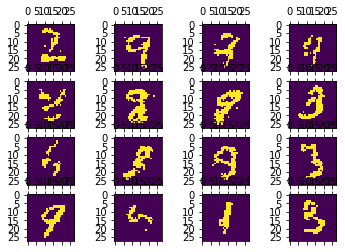

In [33]:
keys = jr.split(key, 16)
fig, axs = plt.subplots(4, 4)
for i in range(16):
    axs[i // 4, i % 4].matshow(jnp.reshape(NADE_sample(model, keys[i]), (28, 28)))

Weight matrices from the model.

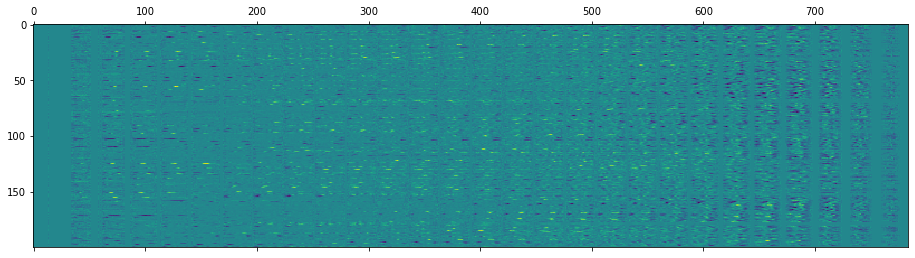

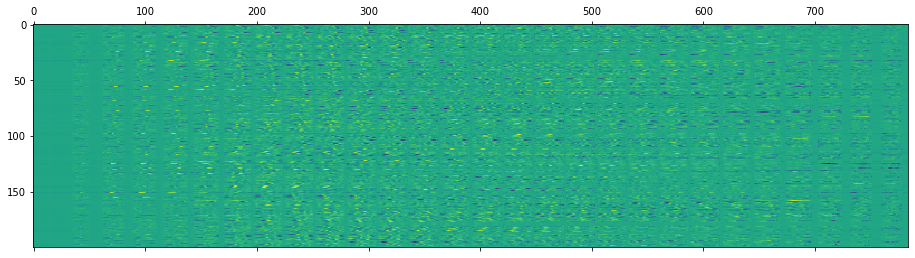

In [34]:
plt.matshow(model[0])
plt.matshow(model[1])

A few random rows from weight matrix W, displayed as square layers.

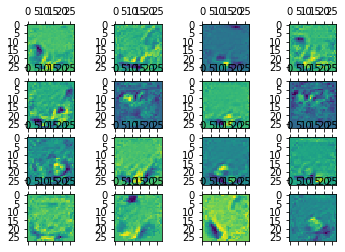

In [22]:
fig, axs = plt.subplots(4, 4)
choices = jr.choice(key, model[0], (16,))
for i in range(16):
    axs[i // 4, i % 4].matshow(jnp.reshape(choices[i], (28,28)))

Output of model on a few elements from the training set.

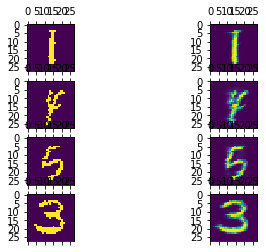

In [23]:
example = jr.choice(key, tr, (4,))
fig, axs = plt.subplots(4,2)
for i in range(4):
    axs[i, 0].matshow(jnp.reshape(example[i], (28, 28)))
    axs[i, 1].matshow(jnp.reshape(NADE_forward(model, example[i]), (28, 28)))